In [1]:
import tensorflow as tf


# Get list of available GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    # Additional information about GPUs
    for gpu in gpu_devices:
        print(gpu)
else:
    print("GPU is not available")

GPU is available
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/train.csv")
test = pd.read_csv("C:/Users/RAZER/Downloads/dataset/aptos/test.csv")
#submission= pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


N_CLASSES = train['diagnosis'].nunique()
N_CLASSES




# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()





train_datagen=ImageDataGenerator(rescale=1./255, 
                                validation_split=0.2,
                                horizontal_flip=True)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')





valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="C:/Users/RAZER/Downloads/dataset/aptos/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation')




test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "C:/Users/RAZER/Downloads/dataset/aptos/test_images/",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50


import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
from keras.models import load_model
aptos_resnet_model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

In [6]:
"""loss, accuracy = aptos_resnet_model.evaluate(train_generator)
print("Train loss:", loss, "Train accuracy:", accuracy)

test_loss, test_accuracy = aptos_resnet_model.evaluate(test_generator)
print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

val_loss, val_accuracy = aptos_resnet_model.evaluate(valid_generator)
print("Validation loss:", val_loss, "Val accuracy:", val_accuracy)"""

'loss, accuracy = aptos_resnet_model.evaluate(train_generator)\nprint("Train loss:", loss, "Train accuracy:", accuracy)\n\ntest_loss, test_accuracy = aptos_resnet_model.evaluate(test_generator)\nprint("Test loss:", test_loss, "Test accuracy:", test_accuracy)\n\nval_loss, val_accuracy = aptos_resnet_model.evaluate(valid_generator)\nprint("Validation loss:", val_loss, "Val accuracy:", val_accuracy)'

## Lime


In [7]:
"C:\Users\RAZER\Downloads\dataset\aptos\test_images\ff4c945d9b17.png"

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (683669508.py, line 1)

  0%|          | 0/10 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


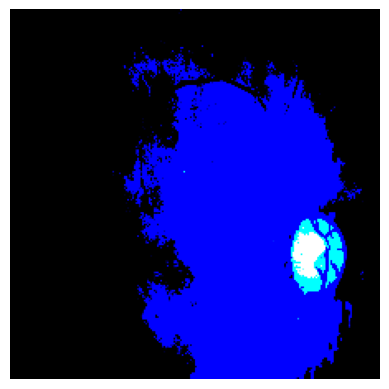

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load your RetinaNet model
model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")

# Load an example image from the APTOS retina dataset
img_path = 'C:/Users/RAZER/Downloads/dataset/aptos/test_images/ff4c945d9b17.png'  # Path to your image
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Define a function to predict with your model
def predict_fn(images):
    preprocessed_images = preprocess_input(images.copy())
    return model.predict(preprocessed_images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(x[0], predict_fn, top_labels=5, hide_color=0, num_samples=10)

# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()


## SHAP

In [17]:
import json

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import shap



data = train_generator.next()
class_names = list(train['diagnosis'].unique())

model = model = load_model("C:/Users/RAZER/Documents/Python Scripts/saved_models/retina/aptos_resnet.h5")



X = data[0]  # Features
y = data[1]  # Labels


X = np.array(X)
y = np.array(y)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)
#masker = shap.maskers.Image("inpaint_ns", X[0].shape)


# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[1:5], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)


Partition explainer: 5it [00:10, 10.81s/it]               


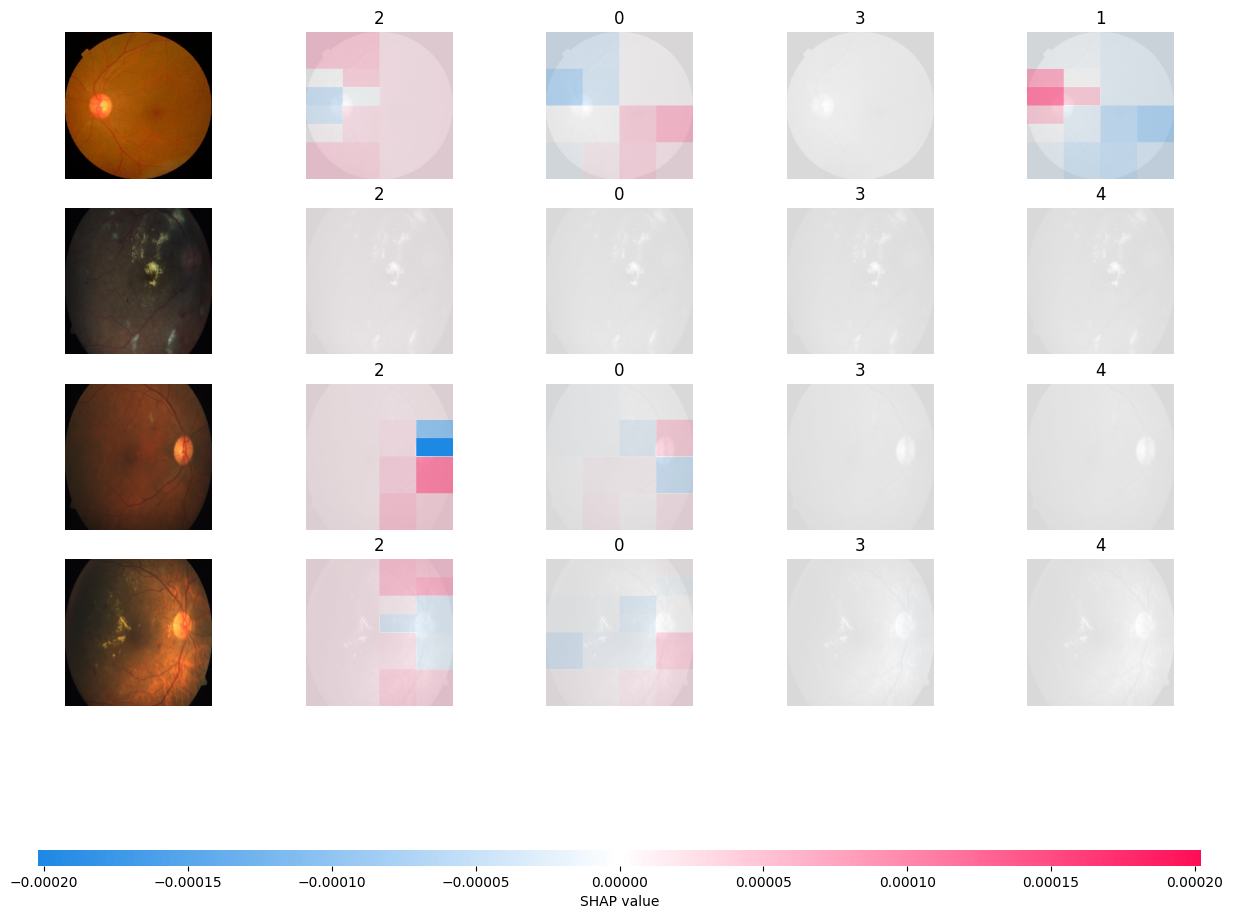

In [18]:
# output with shap values
shap.image_plot(shap_values)

In [12]:




# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(
    X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 3it [00:34, 17.17s/it]               


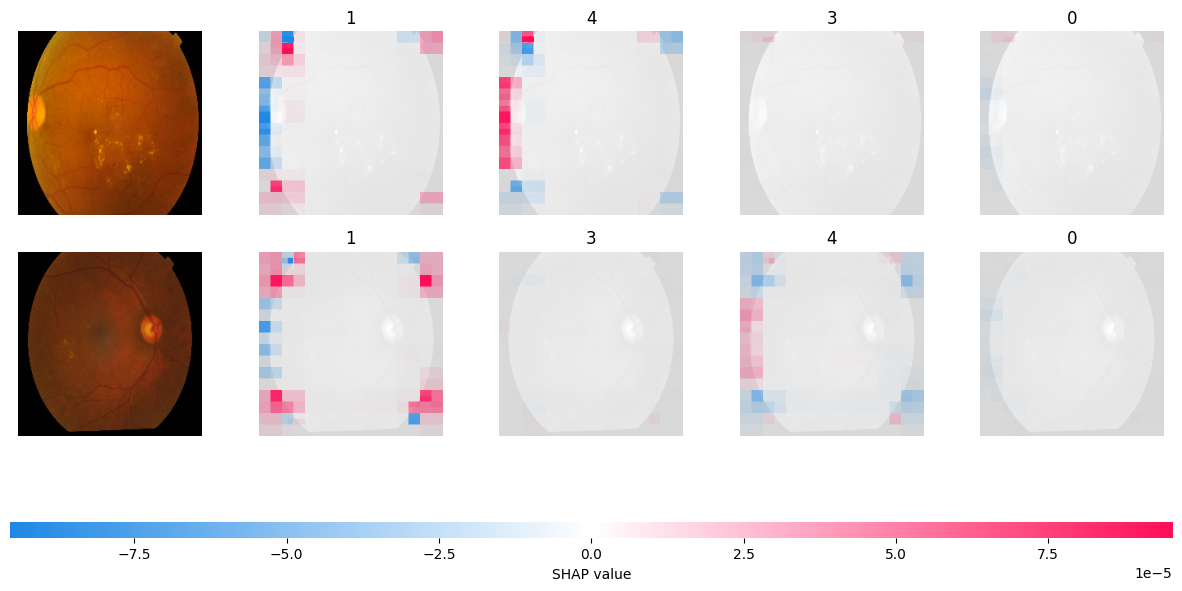

In [13]:
# output with shap values
shap.image_plot(shap_values_fine)

## Grad Cam

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Load an example image (replace with your own image)
image_path = "C:\Users\RAZER\Downloads\dataset\aptos\test_images\ff4c945d9b17.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = preprocess_input(image_array)
image_array = np.expand_dims(image_array, axis=0)

# Get model predictions
predictions = model.predict(image_array)
top_prediction = decode_predictions(predictions, top=1)[0][0]

print(f"Top prediction: {top_prediction[1]} ({top_prediction[2]:.2f})")

# Define the target class index (replace with the desired class)
target_class_index = np.argmax(predictions)

# Get the ResNet50 output for the target class
target_output = model.output[:, target_class_index]

# Get the last convolutional layer
last_conv_layer = model.get_layer('conv5_block3_out')

# Compute the gradient of the target class with respect to the last conv layer
grads = tf.gradients(target_output, last_conv_layer.output)[0]

# Compute the mean gradient values across the spatial dimensions
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each feature map by its corresponding gradient value
heatmap = tf.reduce_mean(last_conv_layer.output, axis=-1)
heatmap *= pooled_grads[..., tf.newaxis]
heatmap = np.maximum(heatmap, 0)

# Normalize the heatmap
heatmap /= np.max(heatmap)

# Resize the heatmap to match the original image size
heatmap = tf.image.resize(heatmap, (224, 224)).numpy()

# Superimpose the heatmap on the original image
superimposed_img = heatmap * image_array[0]

# Display the original image and the superimposed heatmap
plt.imshow(image)
plt.imshow(superimposed_img, alpha=0.5, cmap='jet')
plt.show()


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2676740962.py, line 11)